In [24]:
import sys
import os

# from Utilities.NLP_ModelTrainers.SentenceClassification.MulticlassSentenceClassificationModule import MulticlassSentenceClassificationTrainerModule

from nlp_datasets import YahooDataset
from nlp_datasets import BaseDataset
from nlp_modeltrainers import BaseTrainerModule


import torch
import fastwer
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.nn import Module, Linear, Embedding
from torch.utils.data import DataLoader

from nltk import word_tokenize

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from pytorch_lightning import LightningModule

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = 'cpu'

device = torch.device(dev)

In [2]:
class subwordhash:
    def __init__(self, dataset):
        word_num, hash_len, sample_len = self.average_subword_num(dataset)
        self.word_num = word_num
        self.max_hash = hash_len
        self.max_sample = sample_len
        
    def __call__(self, word):
        return self.subword_hashes(word, max_hash_num = self.max_hash)
    
    def fnv1a(self, txt, K = int(2e6 + 1)):
        # 64 bit fnv-1a
        txt = bytes(txt, 'utf-8')
        hval = 0xcbf29ce484222325
        fnv_prime = 0x100000001b3
        for c in txt:
            hval = hval ^ c
            hval = (hval * fnv_prime) % K
        return hval + 1        

    def subword_hashes(self, word, max_hash_num = None, get_len = False):
        sub_hash = []
        tword = '<' + word + '>'
        sub_hash.append(self.fnv1a(tword))
        for n in range(3,7):
            for i in range(len(tword)-n+1):
                sub_hash.append(self.fnv1a(tword[i:i+n]))
                if len(sub_hash) == max_hash_num:
                    return np.array(sub_hash[:max_hash_num])
        if max_hash_num is not None:
            sub_hash.extend([0]*(max_hash_num - len(sub_hash)))
        if get_len:
            return len(sub_hash)
        return np.array(sub_hash)

    def average_subword_num(self, dataset):
        max_sample_len = 0
        hash_len_dist = {}
        len_dist = {}
        for sample in tqdm(dataset):
            tokens = word_tokenize(sample["input"])
            if len(tokens) not in len_dist:
                len_dist[len(tokens)] = 0
            len_dist[len(tokens)] += 1
            max_sample_len = max(max_sample_len, len(tokens))
            
        for L in list(len_dist):
            hash_len_dist[self.subword_hashes('a'*L, get_len = True)] = len_dist[L]
        
        total = 0
        weighted_hash_len = []
        for L in list(hash_len_dist):
            total += hash_len_dist[L]
            weighted_hash_len.append(hash_len_dist[L]*L)
        avg = sum(weighted_hash_len)/total
        
        return int(total), int(avg), max_sample_len
        

In [4]:
class Word_Preprocessor:
    def __init__(self):
        pass
    
    def __call__(self, sample):
        tokenized = word_tokenize(sample["input"])
        return [w for w in tokenized]

In [3]:
class Hash_Preprocessor:
    def __init__(self):
        pass
    
    def __call__(self, sample):
        tokenized = word_tokenize(sample["input"])
        tokenized_hashes = self.hash_tokenize(tokenized)
        output_id = self.padding(tokenized_hashes, padding_idx=0)
        
        return {"input": output_id, "target": sample['target']-1}
    
    def hash_tokenize(self, data):
        tokenized_id = [subword_hashes(w) for w in data]
        return tokenized_id
    
    def padding(self, data, padding_idx=0):
        data.extend(np.array([[padding_idx]*max_sw_hash_len]*(max_sample_len - len(data))))
        return torch.tensor(data, dtype = torch.long).to(device)

In [8]:
class Misspell_Preprocessor:
    def __init__(self):
        pass
    
    def __call__(self, sample):
        random_freq = True
        tokenized = {i:w for i,w in enumerate(word_tokenize(sample["input"]))}
        tokenized = self.misspell(tokenized, random_freq)
        tokenized_hashes = self.hash_tokenize(tokenized)
        output_id = self.padding(tokenized_hashes, padding_idx=0)
        
        return {"input": output_id, "target": sample['target']-1}
    
    def misspell(self, data, random_freq=False):
        if random_freq: 
            msp_f = np.random.uniform(0.1,0.5)
        else: 
            msp_f = misspell_freq
        misspell_num = int(len(data)*msp_f)
        misspell_idx = np.random.choice(len(data), misspell_num, replace = False)
        m_type = {i:mt for i,mt in enumerate(np.random.randint(0, 4, misspell_num))}
        m_dict = {0:self.delete, 1:self.insert, 2:self.replace, 3:self.swap}
        for i in range(misspell_num):
            mp = data[misspell_idx[i]]
            if len(mp) > 1:
                mp = m_dict[m_type[i]](list(mp))
            else:
                mp = self.replace(list(mp))
            data[misspell_idx[i]] = mp
        return [data[w] for w in sorted(data)]
    
    def delete(self, word):
        idx = np.random.randint(len(word))
        word.pop(idx)
        return ''.join(map(str,word))

    def insert(self, word):
        idx = np.random.randint(len(word))
        letter = np.random.choice(L)
        word.insert(idx, letter)
        return ''.join(map(str,word))

    def replace(self, word):
        idx = np.random.randint(len(word))
        letter = np.random.choice(L)
        word.pop(idx)
        word.insert(idx,letter)
        return ''.join(map(str,word))

    def swap(self, word):
        idx1 = np.random.randint(len(word))
        if idx1 == 0:
            idx2 = idx1 + 1
        elif idx1 == len(word)-1:
            idx2 = idx1 -1
        else:
            idx2 = np.random.choice([idx1+1,idx1-1])
        first_idx = min(idx1,idx2)
        second_idx = max(idx1,idx2)
        temp = word.pop(first_idx)
        word.insert(second_idx, temp)
        return ''.join(map(str,word))
        
    def hash_tokenize(self, data):
        tokenized_id = [subword_hashes(w) for w in data]
        return tokenized_id
    
    def padding(self, data, padding_idx=0):
        data.extend(np.array([[padding_idx]*max_sw_hash_len]*(max_sample_len - len(data))))
        return torch.tensor(data, dtype = torch.long).to(device)

In [5]:
class SubwordEmbedding(Module):
    def __init__(self, num_embeddings, embedding_dim, device, padding_idx = 0):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.device =  device
        self.padding_idx = padding_idx
        
        self.subword_embedding = Embedding(num_embeddings = num_embeddings, 
                                           embedding_dim = embedding_dim, 
                                           padding_idx = padding_idx)
    def forward(self, token_ids):
        # token_ids: (batch_size, word_num, hash_size)
        # return: (batch_size, word_num, embedding_dim)
        debug = False
        
        subword_embed = self.subword_embedding(token_ids)
        # (batch_size, word_num, hash_size, embedding_dim)
        if debug: print("subword_embed.shape: ", subword_embed.shape)
        
        word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).to(self.device)
        # (batch_size, word_num, embedding_dim)
        if debug: print("word_embed.shape: ", word_embed.shape)
        
        if debug: print("\n########################################\n")
        return word_embed
        

In [6]:
class FastTextDataset(Dataset):
    def __init__(self, 
                 word_dataset, 
                 context_size,
                 neg_num,
                 device,
                 uniform = False):
        self.word_dataset = word_dataset
        self.device = device
        w_dict, w_to_id, v_id_f  = self.make_dict()
        self.word_dict = w_dict
#         self.vocab_freq = v_f
        self.vocab_idx_freq = v_id_f
        self.word_to_idx = w_to_id
        self.context_size = context_size
        self.neg_num = neg_num
        print('Making instances (t,c,[ns])...')
        self.data = np.array(self.get_training_data(context_size, neg_num, uniform), dtype = object)
    
    def __getitem__(self, idx):
        target = torch.from_numpy(subword_hashes(self.word_dict[int(self.data[idx,0])])).to(self.device)
        context = torch.from_numpy(subword_hashes(self.word_dict[int(self.data[idx,1])])).to(self.device)
        negatives = torch.from_numpy(np.array([subword_hashes(self.word_dict[n_idx]) for n_idx in self.data[idx,2]])).to(self.device)
            
        output = {'input':{ 'target':target, 
                            'context':context, 
                            'negatives':negatives},
                  'target':[]}
        return output
        
    def __len__(self):
        return len(self.data)
    
    def make_dict(self):
        word_dict = {}
        word_to_idx = {}
        vocab_freq = {}
        count = 0
        for sample in self.word_dataset:
            for word in sample:
                word_dict[count] = word
                if word not in vocab_freq:
                    vocab_freq[word] = 0
                    word_to_idx[word] = len(vocab_freq)-1
                vocab_freq[word] += 1
                count += 1
        vocab_idx_freq = {word_to_idx[w]:vocab_freq[w] for w in vocab_freq}
        return word_dict, word_to_idx, vocab_idx_freq
    
    def get_training_data(self, context_size, neg_num, uniform):
        t_pos = 0
        training_data = []
        for sample in tqdm(self.word_dataset):
            for tp in range(len(sample)):
                context_pos = []
                for sign in [-1,1]:
                    for window in range(1, context_size+1):
                        c_pos = t_pos + sign*(window)
                        if c_pos not in range(len(sample)):
                            break
                        context_pos.append(c_pos)
                
                vocab_list, vocab_dist = self.negative_dist(t_pos, context_pos, uniform)
                vocab = list(vocab_list)
                for c_pos in context_pos:
                    negative_idxs = np.random.choice(vocab_list, neg_num, p = vocab_dist, replace = True)
                    training_data.append([t_pos, c_pos, negative_idxs])
                t_pos += 1
        return training_data
    
    def negative_dist(self, t_pos, c_pos, uniform):
        vocab_idx_bag = self.vocab_idx_freq.copy()
        exclude_words = []
        for pos in c_pos:
            exclude_words.append(self.word_to_idx[self.word_dict[pos]])
        exclude_words.append(self.word_to_idx[self.word_dict[t_pos]])
        exclude_words = set(exclude_words)
        for w_idx in exclude_words:
            vocab_idx_bag.pop(w_idx)
            
        if uniform:
            noise_dist = np.array([1/len(vocab_idx_bag)]*len(vocab_idx_bag))
        else:
            word_freq = np.array(list(vocab_idx_bag))
            unigram_dist = word_freq/np.sum(word_freq)
            noise_dist = unigram_dist**(0.75)/np.sum(unigram_dist**(0.75))
            
        return list(vocab_idx_bag), noise_dist

In [7]:
class FastTextTrainer(BaseTrainerModule):
    def __init__(self, word_embedding, device, debug = False):
        super().__init__()
        self.word_embedding = word_embedding
        self._device = device
        self.debug = debug
        
    def forward(self, target, context, negatives):
        # (batch_size, embedding_dim)
        target_vec = self.word_embedding(target)
        # (batch_size, embedding_dim)
        context_vec = self.word_embedding(context)
        # (batch_size, negatives_num, embedding_dim)
        negatives_vec = self.word_embedding(negatives)
        
        return target_vec, context_vec, negatives_vec
    
    def entropy_loss_func(self, vec1, vec2):
        """
        vec1: (batch_size, embedding_dim)
        vec2: (batch_size, embedding_dim)
        """
        if self.debug: 
            print('vec1.shape:\t', vec1.shape)
            print('vec2.shape:\t', vec2.shape)
            
        vec_product = torch.mul(vec1, vec2).to(self._device)
        if self.debug: print('vec_product.shape:\t', vec_product.shape)
        """ (batch_size, emb_dim) """
        
        vec_product_sum = vec_product.sum(dim=1).to(self._device)
        if self.debug: print('vec_product_sum.shape:\t', vec_product_sum.shape)
        """ (batch_size) """
        
        positive_loss = F.logsigmoid(vec_product_sum).to(self._device)
        if self.debug: print("positive_loss:\t", positive_loss)
        return positive_loss
    
    def negative_loss_func(self, t_vec, n_vec):
        BMM = torch.bmm(n_vec.neg(), t_vec.unsqueeze(2)).to(self._device)
#         print('BMM.shape:\t', BMM.shape)
        neg_loss = F.logsigmoid(BMM).squeeze(2).sum(1).to(self._device)
        return neg_loss
        
    def loss_func(self, t_vec, c_vec, n_vec):
        positive_loss = self.entropy_loss_func(t_vec, c_vec)
        negative_loss = self.negative_loss_func(t_vec, n_vec)
        
#         print('positive_loss: {} negative_loss: {}'.format(positive_loss.neg(), negative_loss.neg()))
        total_loss = -(positive_loss + negative_loss).mean()
        
        return total_loss
    
    def cal_loss(self, outputs, targets=None):
        t_vec, c_vec, n_vec = outputs

        t_vec = t_vec.float()
        c_vec = t_vec.float()
        n_vec = n_vec.float()
        return self.loss_func(t_vec, c_vec, n_vec)
    
    def cal_metrics(self, outputs, targets=None):
        return None

In [8]:
max_samples = 10000
batch_size = 8
emb_dim = 50
num_emb = int(2e6+1)
context_size = 3
neg_num = 5
uniform = True
max_epochs = 100
class_size = 10
misspell_freq = 0.5

if uniform: dist = 'uniform'
else: dist = 'noisedist'
if max_epochs is None:
    epoch = 'ULepochs'
else: epoch = f'{max_epochs}e'
save_path = f"./SubwordEmbedding/trained_model/trained_model_{emb_dim}d_{dist}_{epoch}_{context_size}w"

In [9]:
dataset = YahooDataset(max_samples=max_samples, local_dir="small_yahoo_dataset")

In [10]:
subword_hashes = subwordhash(dataset.train)

word_num = subword_hashes.word_num
max_sw_hash_len = subword_hashes.max_hash
max_sample_len = subword_hashes.max_sample
print(max_sw_hash_len)
print(max_sample_len)

100%|█████████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:07<00:00, 1176.56it/s]


377
995


In [11]:
word_embedding = SubwordEmbedding(num_embeddings = num_emb, embedding_dim = emb_dim, device = device, padding_idx = 0)

In [12]:
preprocessor = Hash_Preprocessor()
dataset.train.set_preprocessor(preprocessor)
dataset.val.set_preprocessor(preprocessor)
dataset.test.set_preprocessor(preprocessor)

dataloader_train = DataLoader(dataset.train, batch_size = batch_size, shuffle = True)
dataloader_val = DataLoader(dataset.val, batch_size = batch_size, shuffle = False)
dataloader_test = DataLoader(dataset.test, batch_size = batch_size, shuffle = False)

In [13]:
word_dataset = YahooDataset(max_samples=max_samples, local_dir="small_yahoo_dataset_text")

preprocessor = Word_Preprocessor()
word_dataset.train.set_preprocessor(preprocessor)
word_dataset.val.set_preprocessor(preprocessor)
word_dataset.test.set_preprocessor(preprocessor)

In [14]:
fasttext_train_dataset = FastTextDataset(word_dataset.train, context_size, neg_num, device, uniform)
fasttext_val_dataset = FastTextDataset(word_dataset.val, context_size, neg_num, device, uniform)
fasttext_test_dataset = FastTextDataset(word_dataset.test, context_size, neg_num, device, uniform)

fasttext_loader_train = DataLoader(fasttext_train_dataset, batch_size = batch_size, shuffle = True)
fasttext_loader_val = DataLoader(fasttext_val_dataset, batch_size = batch_size, shuffle = False)
fasttext_loader_test = DataLoader(fasttext_test_dataset, batch_size = batch_size, shuffle = False)

  0%|                                                                                               | 0/900 [00:00<?, ?it/s]

Making instances (t,c,[ns])...


  0%|                                                                                               | 0/100 [00:00<?, ?it/s]

Making instances (t,c,[ns])...


  0%|                                                                                              | 0/1000 [00:00<?, ?it/s]

Making instances (t,c,[ns])...


100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.30it/s]


In [15]:
logger = pl.loggers.CSVLogger("SubwordEmbedding/logs", name = f"Fasttext_{emb_dim}_{dist}")
checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath = "SubwordEmbedding/checkpoints",
    filename = 'best_model',
    monitor = 'val_loss',
    mode = 'min'
)
class LitProgressBar(pl.callbacks.ProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True)
        return bar
bar = LitProgressBar()

In [16]:
fasttext_model = FastTextTrainer(word_embedding, device)
torch.cuda.empty_cache()
trainer = pl.Trainer(logger=logger, gpus='0', callbacks=[checkpoint, bar], num_sanity_val_steps=0, max_epochs=max_epochs)
# trainer = pl.Trainer(logger=logger, callbacks=[checkpoint, bar], max_epochs=100)
trainer.fit(fasttext_model, train_dataloader = fasttext_loader_train, val_dataloaders = fasttext_loader_val)

C:\Users\user\anaconda3\lib\site-packages\pytorch_lightning\utilities\device_parser.py:130: LightningDeprecationWarning: Parsing of the Trainer argument gpus='0' (string) will change in the future. In the current version of Lightning, this will select CUDA device with index 0, but from v1.5 it will select gpus [] (same as gpus=0 (int)).
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | word_embedding | SubwordEmbedding | 100 M 
----------------------------------------------------
100 M     Trainable params
0         Non-trainable params
100 M     Total params
400.000   Total estimated model params size (MB)
C:\Users\user\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. 

Training: 0it [00:00, ?it/s]

In [17]:
trainer.test(test_dataloaders = fasttext_loader_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\user\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 126.3598861694336}
--------------------------------------------------------------------------------


[{'test_loss': 126.3598861694336}]

In [18]:
if max_epochs is None:
    epoch = 'ULepochs'
else: epoch = f'{max_epochs}e'
save_path = f"./SubwordEmbedding/trained_model/trained_model_{emb_dim}d_{dist}_{epoch}_{context_size}w"

In [19]:
torch.save(word_embedding.state_dict(), save_path)

In [20]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2070'

In [21]:
def similarity_eval(word_corpus, word_embedding):
    mae = []
    less = []
    more = []
    similarities = []
    target_similarities = []
    for w in tqdm(word_corpus):
        w1 = subword_hashes(w[0])
        w2 = subword_hashes(w[1])
        subword_embed = word_embedding.subword_embedding(torch.tensor([w1,w2],dtype = torch.long)).to(device)
        word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).unsqueeze(1).to(device)
#         print(word_embed[0].shape, word_embed[1].shape)
        model_sim = float(F.cosine_similarity(word_embed[0], word_embed[1]))
        similarities.append(model_sim)
        target_sim = 1 - fastwer.score_sent(w[0], w[1], char_level = True)/100
        target_similarities.append(target_sim)
        mae.append(abs(target_sim - model_sim))
        if target_sim - model_sim >=0:
            less.append(abs(target_sim - model_sim))
        elif target_sim - model_sim < 0:
            more.append(abs(target_sim - model_sim))
            
    print(f"MAE: {np.mean(mae)}")
    print(f"MAE (More): {np.mean(more)}")
    print(f"MAE (Less): {np.mean(less)}")
    plt.figure(figsize=[20,5])
    plt.plot(similarities)
    plt.plot(target_similarities)
    plt.xticks(range(0,20), labels=range(1,21))
    plt.grid()
    plt.show()
    

In [22]:
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/misspellings_corpus.txt", "r") as f:
    misspellings_corpus = [line.split(":") for line in f.read().split("\n")]

100%|███████████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 1429.95it/s]


MAE: 0.44295227504034107
MAE (More): 0.14138065464794636
MAE (Less): 0.44415856152191063


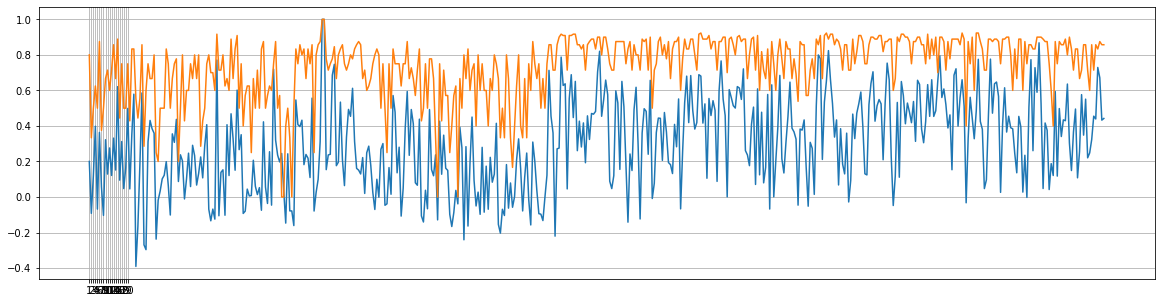

In [25]:
similarity_eval(misspellings_corpus, word_embedding)

In [ ]:
# class test(Module):
    
#     def __init__(self):
#         super().__init__()
#         self.embed = Embedding(20, 5)
#         self.embed.weight.data.uniform_(-0.05,0.05)
        
#     def forward(self):
#         idx = torch.tensor([0,1], dtype = torch.long)
#         multiplier = self.embed(idx)
#         target = torch.tensor([[i for i in range(5)]], dtype = torch.long)
#         print("idx.shape: ", idx.shape)
#         print("idx: ", idx)
#         print("\nmultiplier.shape: ", multiplier.shape)
#         print("multiplier: ", multiplier)
#         print("\ntarget.shape: ", target.shape)
#         print("target: ", target)
        
#         product = torch.mul(target, multiplier)
#         print("\nproduct.shape: ", product.shape)
#         print("product: ", product)
#         emb_sum = torch.sum(product, dim=1)
#         print("\nsum.shape: ", emb_sum.shape)
#         print("sum: ", emb_sum)
        
#         noise_dist = torch.ones(20)
#         ng = torch.multinomial(noise_dist,5, replacement = True)
        
#         return

In [ ]:
print(int(True))

In [ ]:
'''
100d
- uniform: 140 test
- noise: 
50d
- uniform 127 test
'''